In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV




In [2]:
# Load data
df = pd.read_excel(r"C:\Users\Admin\WORK\Time_series_analysis\data\task_1_2.xlsx", sheet_name="Training")
df.head()

,ID,Target,P1,P2,P3,P4,P5,P6,P7,P8,...,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
0,283,1,0.0,NaN,NaN,10,0,1.02273,1.01608,1.55268,...,831.68333,783.81667,171.33333,818.15000,0.62772,0.13333,0.00000,6.41893,0.97122,6.41893
1,342,0,0.0,30.00000,6.80153,0,0,1.00000,1.65348,1.14852,...,195.13889,168.30000,81.00000,NaN,6.32407,0.26667,0.33333,NaN,1.60714,3.44800
2,631,0,0.0,30.00000,9.60267,0,0,1.00000,0.84143,NaN,...,226.10556,207.41667,110.00000,184.49444,2.25635,0.00000,0.06667,NaN,0.75000,8.08000
3,1165,0,0.0,30.33333,15.32553,0,0,0.98901,0.88114,NaN,...,567.53889,441.52778,194.00000,625.32222,2.74469,0.13333,0.40000,13.50400,0.98119,13.50400
4,1469,0,0.0,28.00000,7.54133,0,0,0.92857,1.21447,0.60138,...,154.80556,86.64444,71.66667,53.45000,0.91130,0.46667,0.40000,NaN,0.40171,3.44800


In [3]:
features = [column for column in df.columns if column.startswith('P')]
target = 'Target'

In [4]:
X, y = df[features].values, df[target].values
X.shape, y.shape

((10000, 31), (10000,))

In [5]:
np.isnan(X).sum(axis=0)

array([   0, 1508, 1477,    0,    0,    0,    0, 1518,    0,    0,    0,
          0,    0,    0,    0, 1525,    0,    0,    0,    0,    0,    0,
          0,    0, 1504,    0,    0,    0, 1533,    0,    0])

In [6]:
from sklearn.impute import KNNImputer
nan = np.nan
imputer = KNNImputer(n_neighbors=15, weights="uniform")
X_inp = imputer.fit_transform(X)
np.isnan(X_inp).sum(axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, = train_test_split(X_inp, y, test_size=0.3, stratify=y)
X_train.shape, X_test.shape

((7000, 31), (3000, 31))

In [10]:
# Создаем модель
model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'criterion': ['gini', 'entropy'],  # Критерий разделения
    'max_depth': [3, 5, 7, None],      # Максимальная глубина (None = без ограничений)
    'min_samples_split': [2, 5, 10],   # Минимальное число образцов для разделения узла
    'min_samples_leaf': [1, 2, 4]      # Минимальное число образцов в листе
}

In [11]:
# Инициализация GridSearchCV
grid_search = GridSearchCV(
    estimator=model,          # Модель для оптимизации
    param_grid=param_grid,    # Сетка параметров
    cv=5,                     # Количество фолдов кросс-валидации
    scoring='accuracy',       # Метрика для оценки (можно 'f1', 'roc_auc' и др.)
    n_jobs=8,                # Использовать все ядра CPU
    verbose=1                 # Вывод лога (1 - минимальный, 2 - подробный)
)

# Запуск поиска
result = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [12]:
y_score = result.best_estimator_.predict_proba(X_test)[:, 1]
y_pred = result.best_estimator_.predict(X_test)
y_score.shape, y_pred.shape

((3000,), (3000,))

In [13]:
roc_auc_score(y_score=y_score, y_true=y_test)


0.7230726666666666

In [14]:
confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[1086,  414],
       [ 557,  943]], dtype=int64)

In [15]:
dict(
    recall = recall_score(y_pred=y_pred, y_true=y_test),
    accuracy = accuracy_score (y_pred=y_pred, y_true=y_test),
    precision = precision_score(y_pred=y_pred, y_true=y_test),
    f1 = f1_score(y_pred=y_pred, y_true=y_test)
)

{'recall': 0.5586666666666666,
 'accuracy': 0.6523333333333333,
 'precision': 0.6874487284659557,
 'f1': 0.6164030893710923}

In [17]:
pd.Series(
    data=result.best_estimator_.feature_importances_,
      index=features
).sort_values(
    ascending=False
).head()

P23    0.418616
P16    0.220590
P6     0.137629
P8     0.088708
P10    0.047900
dtype: float64

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)  # Выбор 10 лучших признаков
X_new_tr = selector.fit_transform(X_train, y_train)
X_nex_ts = selector.transform(X_test)
X_nex_ts = selector.transform(X_test)

In [20]:
feature_names = df.feature_names
selected_features = selector.get_support(indices=True)

selected_features
print("\nВыбранные признаки:", [feature_names[i] for i in selected_features])



AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [33]:
# выведем информацию для интерпретации построенной модели
print(export_text(result.best_estimator_))

|--- feature_22 <= 125.32
|   |--- feature_15 <= 1.84
|   |   |--- feature_9 <= 10.17
|   |   |   |--- feature_7 <= 0.03
|   |   |   |   |--- feature_1 <= 28.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_1 >  28.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_7 >  0.03
|   |   |   |   |--- feature_2 <= 3.64
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_2 >  3.64
|   |   |   |   |   |--- class: 1
|   |   |--- feature_9 >  10.17
|   |   |   |--- feature_3 <= 9.50
|   |   |   |   |--- feature_22 <= 40.02
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_22 >  40.02
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  9.50
|   |   |   |   |--- feature_30 <= 24.73
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_30 >  24.73
|   |   |   |   |   |--- class: 0
|   |--- feature_15 >  1.84
|   |   |--- feature_5 <= 0.87
|   |   |   |--- feature_3 <= 2.50
|   |   |   |   |--- feature_5 <= 0.64
|   |   |   |  

In [89]:
# проведем классификацию
data_predict = cl.predict(x_test)
accuracy = accuracy_score(y_test, data_predict)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.64


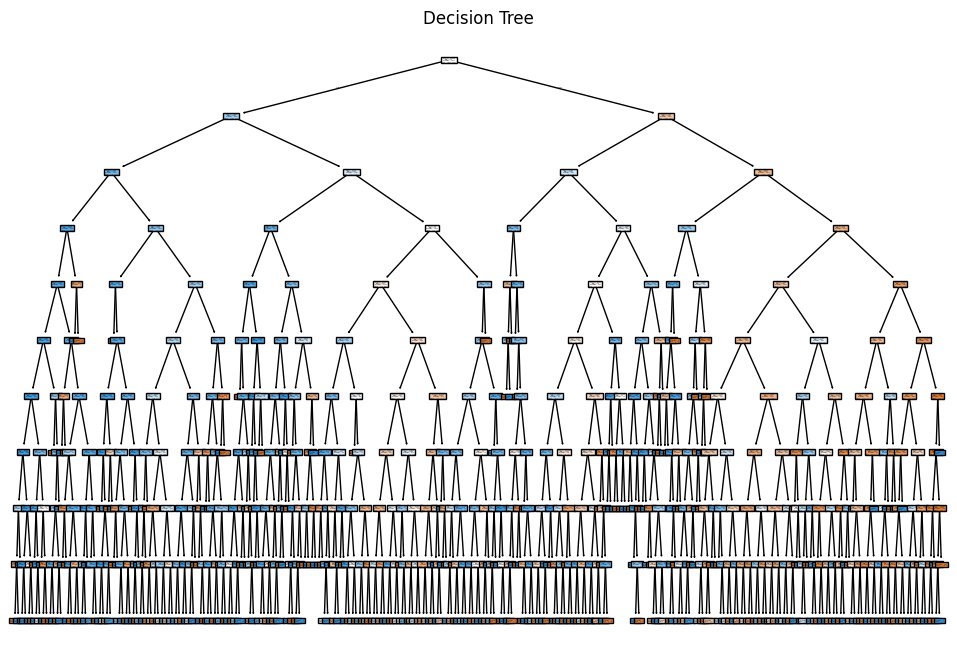

In [97]:
plt.figure(figsize=(12, 8))
plot_tree(cl, feature_names= None, class_names= None, filled=True)
plt.title("Decision Tree")
plt.show()

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import KNNImputer
# from scipy.stats import randint
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline([
#     ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
#     ('model', RandomForestClassifier())
# ])


# param_dist = {
#     'imputer__n_neighbors': randint(2, 15),
#     'imputer__weights': ['uniform', 'distance']
# }

# random_search = RandomizedSearchCV(
#     pipeline, param_dist, n_iter=10, cv=5, scoring='accuracy'
# )
# random_search.fit(X_train, y_train)

In [ ]:
start_tree = 3  
end_tree = 4    
for i in range(start_tree, end_tree):
    plt.figure(figsize=(40, 20), dpi=200)  
    plot_tree(best_model_2, 
              num_trees=i,  
              rankdir='LR',  
              ax=plt.gca())
    plt.title(f'Дерево {i}', fontsize=20)
    plt.tight_layout()
    plt.show()